Coordonnées des pixels blancs :
[[   1  978]
 [   1  979]
 [   1  980]
 ...
 [2046 1078]
 [2046 1089]
 [2046 1090]]


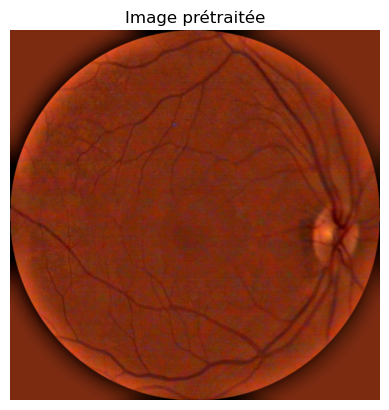

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def fundus_roi(image, mask=None):
    b, g, r = cv2.split(image)
    threshold = 40
    _, roi = cv2.threshold(r, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(np.uint8)
    white_pixels = np.argwhere(roi == 1)

    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}

    print("Coordonnées des pixels blancs :")
    print(white_pixels)

    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))

    return {"roi": roi, "diameter": diameter, "image": image}

def mean_filter(image, kernel_size):
    kernel_size = int(kernel_size)  # Assurez-vous que kernel_size est un entier
    filtered_image = cv2.blur(image, (kernel_size, kernel_size))
    return filtered_image.astype(np.uint8)  # Assurez-vous que le type est np.uint8

def illumination_equalization(image, diameter=None, roi=None):
    if diameter is None:
        print('Erreur: Le diamètre est None. Impossible de continuer.')
        return None

    kernel_size = int(diameter / 10)
    b, g, r = cv2.split(image)
    b_filtered = mean_filter(b, kernel_size)
    g_filtered = mean_filter(g, kernel_size)
    r_filtered = mean_filter(r, kernel_size)

    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)

    b_final = cv2.addWeighted(b, 1, b_filtered, -1, mean_b)
    g_final = cv2.addWeighted(g, 1, g_filtered, -1, mean_g)
    r_final = cv2.addWeighted(r, 1, r_filtered, -1, mean_r)

    image_final = cv2.merge([b_final, g_final, r_final])
    return image_final.astype(np.uint8)  # Assurez-vous que le type est np.uint8

def denoising(image, diameter=None):
    b, g, r = cv2.split(image)
    kernel_size = int(diameter / 360)  # Convertir en entier
    b_filtered = mean_filter(b, kernel_size)
    g_filtered = mean_filter(g, kernel_size)
    r_filtered = mean_filter(r, kernel_size)

    denoising_image = cv2.merge([b_filtered, g_filtered, r_filtered])
    return denoising_image.astype(np.uint8)  # Assurez-vous que le type est np.uint8

def adaptive_contrast_equalization(image):
    b, g, r = cv2.split(image)
    E_x2_b = np.mean(b ** 2)
    E_x2_g = np.mean(g ** 2)
    E_x2_r = np.mean(r ** 2)
    E_x_b = np.mean(b)
    E_x_g = np.mean(g)
    E_x_r = np.mean(r)

    std_b = E_x2_b - E_x_b
    std_g = E_x2_g - E_x_g
    std_r = E_x2_r - E_x_r

    high_pass_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) / 9
    convolution_b = cv2.filter2D(b, -1, 1 - high_pass_filter)
    convolution_g = cv2.filter2D(g, -1, 1 - high_pass_filter)
    convolution_r = cv2.filter2D(r, -1, 1 - high_pass_filter)

    epsilon = 1e-7
    image_contrast_b = b + 1 / (epsilon + std_b) * convolution_b
    image_contrast_g = g + 1 / (epsilon + std_g) * convolution_g
    image_contrast_r = r + 1 / (epsilon + std_r) * convolution_r

    image_final = cv2.merge([image_contrast_b, image_contrast_g, image_contrast_r])
    return image_final.astype(np.uint8)  # Assurez-vous que le type est np.uint8

def apply_intensity_normalization(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def apply_seoud(image):
    data = fundus_roi(image)
    illumination = illumination_equalization(image=data["image"], diameter=data["diameter"], roi=data["roi"])
    denoise = denoising(image=illumination, diameter=data["diameter"])
    contrast = adaptive_contrast_equalization(image=denoise)
    normalized_image = apply_intensity_normalization(contrast)
    return normalized_image

# Chargement de l'image
image = cv2.imread('../data/image_1.png')
if image is None:
    print("Erreur: Impossible de charger l'image.")
else:
    image = image.astype(np.uint8)
    seoud_image = apply_seoud(image)
    plt.imshow(cv2.cvtColor(seoud_image, cv2.COLOR_BGR2RGB))
    plt.title('Image prétraitée')
    plt.axis('off')
    plt.show()
